# How to Use Forecasters in Merlion

This notebook will guide you through using all the key features of forecasters in Merlion. Specifically, we will explain

1. Initializing a forecasting model (including ensembles and automatic model selectors)
1. Training the model
1. Producing a forecast with the model
1. Visualizing the model's predictions
1. Quantitatively evaluating the model
1. Saving and loading a trained model
1. Simulating the live deployment of a model using a `ForecastEvaluator`

We will be using a single example time series for this whole notebook. We load it now:

100%|██████████| 414/414 [00:00<00:00, 709.91it/s]


Has missing data: False


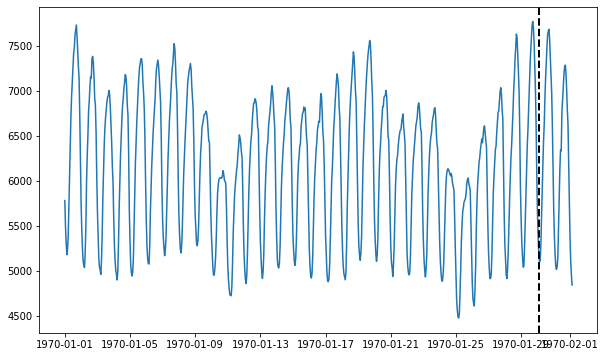

700 points in train split, 48 points in test split.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from merlion.utils.time_series import TimeSeries
from ts_datasets.forecast import M4

# Load the time series
# time_series is a time-indexed pandas.DataFrame
# trainval is a time-indexed pandas.Series indicating whether each timestamp is for training or testing
time_series, metadata = M4(subset="Hourly")[5]
trainval = metadata["trainval"]

# Is there any missing data?
timedeltas = np.diff(time_series.index)
print(f"Has missing data: {any(timedeltas != timedeltas[0])}")

# Visualize the time series and draw a dotted line to indicate the train/test split
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time_series)
ax.axvline(time_series[trainval].index[-1], ls="--", lw="2", c="k")
plt.show()

# Split the time series into train/test splits, and convert it to Merlion format
train_data = TimeSeries.from_pd(time_series[trainval])
test_data  = TimeSeries.from_pd(time_series[~trainval])
print(f"{len(train_data)} points in train split, "
      f"{len(test_data)} points in test split.")

## Model Initialization

In this notebook, we will use three different forecasting models:
1. ARIMA (a classic stochastic process model)
2. Prophet (Facebook's popular time series forecasting model)
3. MSES (the Multi-Scale Exponential Smoothing model, developed in-house)

Let's start by initializing each of them.

In [2]:
# Import models & configs
from merlion.models.forecast.arima import Arima, ArimaConfig
from merlion.models.forecast.prophet import Prophet, ProphetConfig
from merlion.models.forecast.smoother import MSES, MSESConfig

# Import data pre-processing transforms
from merlion.transform.base import Identity
from merlion.transform.resample import TemporalResample

# All models are initialized using the syntax ModelClass(config),
# where config is a model-specific configuration object. This is where
# you specify any algorithm-specific hyperparameters, as well as any
# data pre-processing transforms.

# ARIMA assumes that input data is sampled at a regular interval,
# so we set its transform to resample at that interval. We must also specify
# a maximum prediction horizon.
config1 = ArimaConfig(max_forecast_steps=100, order=(20, 1, 5),
                      transform=TemporalResample(granularity="1h"))
model1  = Arima(config1)


# Prophet has no real assumptions on the input data (and doesn't require
# a maximum prediction horizon), so we skip data pre-processing by using
# the Identity transform.
config2 = ProphetConfig(max_forecast_steps=None, transform=Identity())
model2  = Prophet(config2)


# MSES assumes that the input data is sampled at a regular interval,
# and requires us to specify a maximum prediction horizon. We will
# also specify its look-back hyperparameter to be 60 here
config3 = MSESConfig(max_forecast_steps=100, max_backstep=60,
                     transform=TemporalResample(granularity="1h"))
model3  = MSES(config3)

Now that we have initialized the individual models, we will also combine them in two different ensembles: `ensemble` simply takes the mean prediction of each individual model, and `selector` selects the best individual model based on its sMAPE (symmetric Mean Average Precision Error). The sMAPE is a metric used to evaluate the quality of a continuous forecast. For ground truth $y \in \mathbb{R}^T$ and prediction $\hat{y} \in \mathbb{R}^T$, the sMAPE is computed as

$$
\mathrm{sMAPE}(y, \hat{y}) = \frac{200}{T} \sum_{t = 1}^{T} \frac{\lvert \hat{y}_t - y_t \rvert}{\lvert\hat{y}_t\rvert + \lvert y_t \rvert}
$$

In [3]:
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.ensemble.combine import Mean, ModelSelector
from merlion.models.ensemble.forecast import ForecasterEnsemble, ForecasterEnsembleConfig

# The ForecasterEnsemble is a forecaster, and we treat it as a first-class model.
# Its config takes a combiner object, specifying how you want to combine the 
# predictions of individual models in the ensemble. There are two ways to specify
# the actual models in the ensemble, which we cover below.

# The first way to specify the models in the ensemble is to provide them when
# initializing the ForecasterEnsembleConfig.
#
# The combiner here will simply take the mean prediction of the ensembles here
ensemble_config = ForecasterEnsembleConfig(
    combiner=Mean(), models=[model1, model2, model3])
ensemble = ForecasterEnsemble(config=ensemble_config)


# Alternatively, you can directly specify the models when initializing the
# ForecasterEnsemble itself.
#
# The combiner here uses the sMAPE to compare individual models, and
# selects the model with the lowest sMAPE
selector_config = ForecasterEnsembleConfig(
    combiner=ModelSelector(metric=ForecastMetric.sMAPE))
selector = ForecasterEnsemble(
    config=selector_config, models=[model1, model2, model3])

## Model Training

All forecasting models (and ensembles) share the same API for training. The `train()` method returns the model's predictions and standard error of those predictions on the training data. Note that the standard error is just `None` if the model doesn't support uncertainty estimation (this is the case for MSES and ensembles).

In [4]:
print(f"Training {type(model1).__name__}...")
forecast1, stderr1 = model1.train(train_data)

print(f"\nTraining {type(model2).__name__}...")
forecast2, stderr2 = model2.train(train_data)

print(f"\nTraining {type(model3).__name__}...")
forecast3, stderr3 = model3.train(train_data)

print("\nTraining ensemble...")
forecast_e, stderr_e = ensemble.train(train_data)

print("\nTraining model selector...")
forecast_s, stderr_s = selector.train(train_data)

print("Done!")

Training Arima...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Training Prophet...

Training MSES...


INFO:merlion.models.ensemble.forecast:Training model 1/3 (Arima)...



Training ensemble...


INFO:merlion.models.ensemble.forecast:Training model 2/3 (Prophet)...
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Training model 3/3 (MSES)...
INFO:merlion.models.ensemble.forecast:Training model 1/3 (Arima)...



Training model selector...


INFO:merlion.models.ensemble.forecast:Training model 2/3 (Prophet)...
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Training model 3/3 (MSES)...
INFO:merlion.models.ensemble.forecast:Evaluating validation performance...
INFO:merlion.models.ensemble.forecast:Re-training model 1/3 (Arima) on full data...
INFO:merlion.models.ensemble.forecast:Re-training model 2/3 (Prophet) on full data...
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Re-training model 3/3 (MSES) on full data...
INFO:merlion.models.ensemble.forecast:Models used (of 3): 1 (Arima)


Done!


## Model Inference

To obtain a forecast from a trained model, we simply call `model.forecast()` with the Unix timestamps at which we the model to generate a forecast. In many cases, you may obtain these directly from a time series as shown below.

In [5]:
# Truncate the test data to ensure that we are within each model's maximum
# forecast horizon.
sub_test_data = test_data[:50]

# Obtain the time stamps corresponding to the test data
time_stamps = sub_test_data.univariates[sub_test_data.names[0]].time_stamps

# Get the forecast & standard error of each model. These are both
# merlion.utils.TimeSeries objects. Note that the standard error is None for
# models which don't support uncertainty estimation (like MSES and all
# ensembles).
forecast1, stderr1 = model1.forecast(time_stamps=time_stamps)
forecast2, stderr2 = model2.forecast(time_stamps=time_stamps)

# You may optionally specify a time series prefix as context. If one isn't
# specified, the prefix is assumed to be the training data. Here, we just make
# this dependence explicit. More generally, this feature is useful if you want
# to use a pre-trained model to make predictions on data further in the future
# from the last time it was trained.
forecast3, stderr3 = model3.forecast(time_stamps=time_stamps, time_series_prev=train_data)

# The same options are available for ensembles as well, though the stderr is None
forecast_e, stderr_e = ensemble.forecast(time_stamps=time_stamps)
forecast_s, stderr_s = selector.forecast(time_stamps=time_stamps, time_series_prev=train_data)

## Model Visualization and Quantitative Evaluation

It is fairly transparent to visualize a model's forecast and also quantitatively evaluate the forecast, using standard metrics like sMAPE. We show examples for all five models below.

Below, we quantitatively evaluate the models using the sMAPE metric. However, the `ForecastMetric` enum includes a number of other options as well. In general, you may use the syntax
```
ForecastMetric.<metric_name>.value(ground_truth=ground_truth, predict=forecast)
```
where `<metric_name>` is the name of the evaluation metric (see the API docs for details and more options), `ground_truth` is the original time series, and `forecast` is the forecast returned by the model. We show concrete examples with `ForecastMetric.sMAPE` below.

Arima sMAPE is 3.768


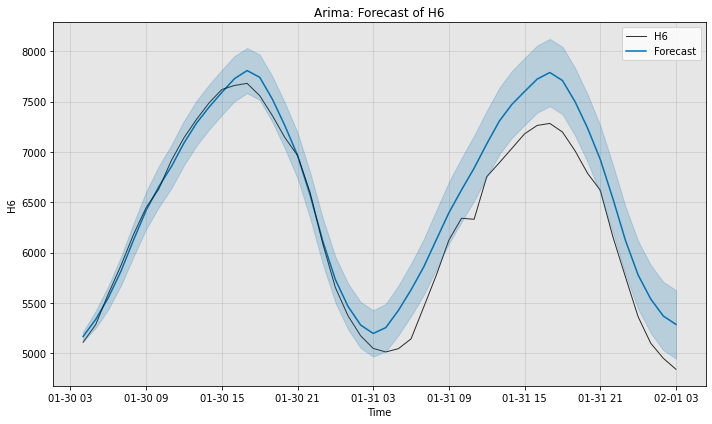

In [6]:
from merlion.evaluate.forecast import ForecastMetric

# We begin by computing the sMAPE of ARIMA's forecast (scale is 0 to 100)
smape1 = ForecastMetric.sMAPE.value(ground_truth=sub_test_data,
                                    predict=forecast1)
print(f"{type(model1).__name__} sMAPE is {smape1:.3f}")

# Next, we can visualize the actual forecast, and understand why it
# attains this particular sMAPE. Since ARIMA supports uncertainty
# estimation, we plot its error bars too.
fig, ax = model1.plot_forecast(time_series=sub_test_data,
                               plot_forecast_uncertainty=True)
plt.show()

Prophet sMAPE is 2.913


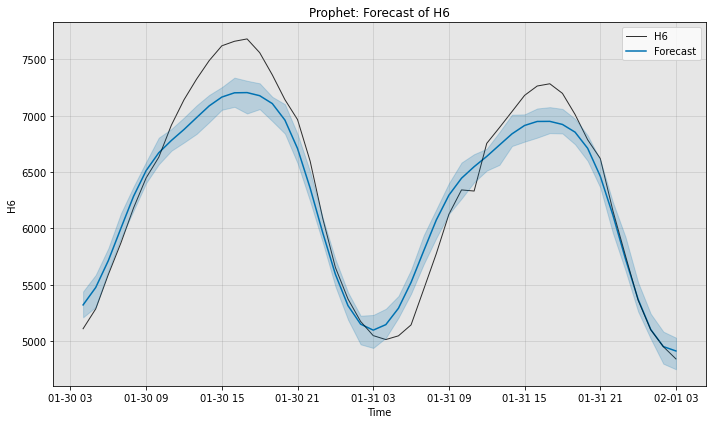

In [7]:
# We begin by computing the sMAPE of Prophet's forecast (scale is 0 to 100)
smape2 = ForecastMetric.sMAPE.value(sub_test_data, forecast2)
print(f"{type(model2).__name__} sMAPE is {smape2:.3f}")

# Next, we can visualize the actual forecast, and understand why it
# attains this particular sMAPE. Since Prophet supports uncertainty
# estimation, we plot its error bars too.
# Note that we can specify time_series_prev here as well, though it
# will not be visualized unless we also supply the keyword argument
# plot_time_series_prev=True.
fig, ax = model2.plot_forecast(time_series=sub_test_data,
                               time_series_prev=train_data,
                               plot_forecast_uncertainty=True)
plt.show()

MSES sMAPE is 4.377


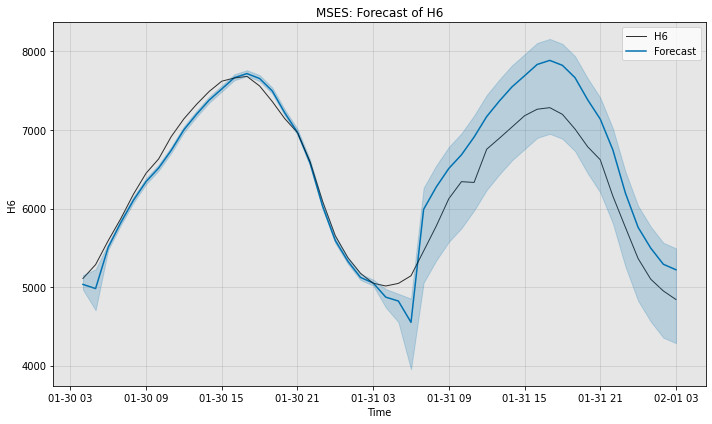

In [8]:
# We begin by computing the sMAPE of MSES's forecast (scale is 0 to 100)
smape3 = ForecastMetric.sMAPE.value(sub_test_data, forecast3)
print(f"{type(model3).__name__} sMAPE is {smape3:.3f}")

# Next, we visualize the actual forecast, and understand why it 
# attains this particular sMAPE.
fig, ax = model3.plot_forecast(time_series=sub_test_data,
                               plot_forecast_uncertainty=True)
plt.show()

Ensemble sMAPE is 2.590


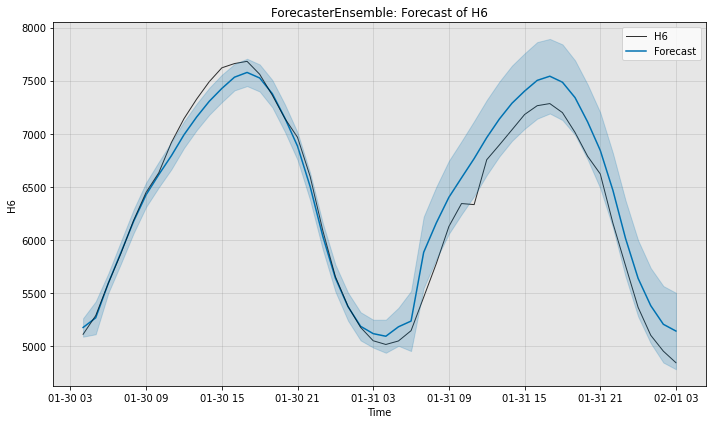

In [9]:
# Compute the sMAPE of the ensemble's forecast (scale is 0 to 100)
smape_e = ForecastMetric.sMAPE.value(sub_test_data, forecast_e)
print(f"Ensemble sMAPE is {smape_e:.3f}")

# Visualize the forecast.
fig, ax = ensemble.plot_forecast(time_series=sub_test_data,
                                 plot_forecast_uncertainty=True)
plt.show()

Selector sMAPE is 3.768


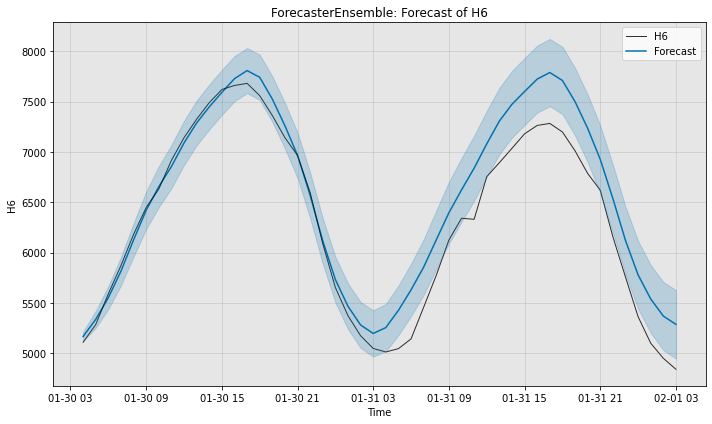

In [10]:
# Compute the sMAPE of the selector's forecast (scale is 0 to 100)
smape_s = ForecastMetric.sMAPE.value(sub_test_data, forecast_s)
print(f"Selector sMAPE is {smape_s:.3f}")

# Visualize the forecast.
fig, ax = selector.plot_forecast(time_series=sub_test_data,
                                 plot_forecast_uncertainty=True)
plt.show()

## Saving & Loading Models

All models have a `save()` method and `load()` class method. Models may also be loaded with the assistance of the `ModelFactory`, which works for arbitrary models. The `save()` method creates a new directory at the specified path, where it saves a `json` file representing the model's config, as well as a binary file for the model's state.

We will demonstrate these behaviors using our `Prophet` model (`model2`) for concreteness.

In [11]:
import json
import os
import pprint
from merlion.models.factory import ModelFactory

# Save the model
os.makedirs("models", exist_ok=True)
path = os.path.join("models", "prophet")
model2.save(path)

# Print the config saved
pp = pprint.PrettyPrinter()
with open(os.path.join(path, "config.json")) as f:
    print(f"{type(model2).__name__} Config")
    pp.pprint(json.load(f))

# Load the model using Prophet.load()
model2_loaded = Prophet.load(dirname=path)

# Load the model using the ModelFactory
model2_factory_loaded = ModelFactory.load(name="Prophet", model_path=path)

Prophet Config
{'daily_seasonality': 'auto',
 'dim': 1,
 'holidays': None,
 'max_forecast_steps': None,
 'model_path': '/Users/abhatnagar/Desktop/Merlion_public/examples/forecast/models/prophet/model.pkl',
 'seasonality_mode': 'additive',
 'target_seq_index': 0,
 'transform': {'name': 'Identity'},
 'uncertainty_samples': 100,
 'weekly_seasonality': 'auto',
 'yearly_seasonality': 'auto'}


We can do the same exact thing with ensembles! Note that the ensemble stores its underlying models in a nested structure. Additionally, the combiner (which is saved in the `ForecasterEnsembleConfig`), keeps track of the sMAPE achieved by each model (the `metric_values` key). This is all reflected in the config.

In [12]:
# Save the selector
path = os.path.join("models", "selector")
selector.save(path)

# Print the config saved. Note that we've saved all individual models,
# and their paths are specified under the model_paths key.
pp = pprint.PrettyPrinter()
with open(os.path.join(path, "config.json")) as f:
    print(f"Selector Config")
    pp.pprint(json.load(f))

# Load the selector
selector_loaded = ForecasterEnsemble.load(dirname=path)

# Load the selector using the ModelFactory
selector_factory_loaded = ModelFactory.load(name="ForecasterEnsemble", model_path=path)

Selector Config
{'combiner': {'abs_score': False,
              'metric': 'ForecastMetric.sMAPE',
              'metric_values': [5.479063255045728,
                                8.691874724892063,
                                17.72980301555831],
              'n_models': 3,
              'name': 'ModelSelector'},
 'dim': 1,
 'max_forecast_steps': None,
 'model_path': '/Users/abhatnagar/Desktop/Merlion_public/examples/forecast/models/selector/model.pkl',
 'models': [{'dim': 1,
             'max_forecast_steps': 100,
             'name': 'Arima',
             'order': [20, 1, 5],
             'target_seq_index': 0,
             'transform': {'aggregation_policy': 'Mean',
                           'granularity': 3600.0,
                           'missing_value_policy': 'Interpolate',
                           'name': 'TemporalResample',
                           'origin': 0.0,
                           'remove_non_overlapping': True,
                           'trainable_granul

## Simulating Live Model Deployment

A typical model deployment scenario is as follows:
1. Train an initial model on some recent historical data
1. At a regular interval `cadence`, obtain the model's forecast for a certain `horizon`
1. At a regular interval `retrain_freq`, retrain the entire model on the most recent data
1. Optionally, specify a maximum amount of data (`train_window`) that the model should use for training

We provide a `ForecastEvaluator` object which simulates the above deployment scenario, and also allows a user to evaluate the quality of the forecaster according to an evaluation metric of their choice. We illustrate two examples below, using ARIMA for the first example, and the model selector for the second.

In [13]:
from merlion.evaluate.forecast import ForecastEvaluator, ForecastEvaluatorConfig, ForecastMetric

def create_evaluator(model):
    # Re-initialize the model, so we can re-train it from scratch
    model.reset()

    # Create an evaluation pipeline for the model, where we
    # -- get the model's forecast every hour
    # -- have the model forecast for a horizon of 6 hours
    # -- re-train the model every 12 hours
    # -- when we re-train the model, retrain it on only the past 2 weeks of data
    evaluator = ForecastEvaluator(
        model=model, config=ForecastEvaluatorConfig(
            cadence="1h", horizon="6h", retrain_freq="12h", train_window="14d")
    )
    return evaluator

First, let's evaluate ARIMA.

In [14]:
# Obtain the results of running the evaluation pipeline for ARIMA.
# These result objects are to be treated as a black box, and should be
# passed directly to the evaluator's evaluate() method.
model1_evaluator = create_evaluator(model1)
model1_train_result, model1_test_result = model1_evaluator.get_predict(
    train_vals=train_data, test_vals=test_data)

ForecastEvaluator: 100%|██████████| 169200/169200 [00:08<00:00, 20212.96it/s]


In [15]:
# Evaluate ARIMA's sMAPE and RMSE
smape = model1_evaluator.evaluate(
    ground_truth=test_data,
    predict=model1_test_result,
    metric=ForecastMetric.sMAPE)
rmse  = model1_evaluator.evaluate(
    ground_truth=test_data,
    predict=model1_test_result,
    metric=ForecastMetric.RMSE)
print(f"{type(model1).__name__} sMAPE: {smape:.3f}")
print(f"{type(model1).__name__} RMSE:  {rmse:.3f}")

Arima sMAPE: 2.015
Arima RMSE:  143.416


Next, we will evaluate the ensemble (taking the mean prediction of ARIMA, Prophet, and MSES every time the models are called).

In [16]:
# Obtain the results of running the evaluation pipeline for the ensemble.
# These result objects are to be treated as a black box, and should be
# passed directly to the evaluator's evaluate() method.
ensemble_evaluator = create_evaluator(ensemble)
ensemble_train_result, ensemble_test_result = ensemble_evaluator.get_predict(
    train_vals=train_data, test_vals=test_data)

INFO:merlion.models.ensemble.forecast:Training model 1/3 (Arima)...
INFO:merlion.models.ensemble.forecast:Training model 2/3 (Prophet)...
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Training model 3/3 (MSES)...
ForecastEvaluator:  26%|██▌       | 43200/169200 [00:03<00:10, 12027.46it/s]INFO:merlion.models.ensemble.forecast:Training model 1/3 (Arima)...
INFO:merlion.models.ensemble.forecast:Training model 2/3 (Prophet)...
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Training model 3/3 (MSES)...
ForecastEvaluator:  51%|█████     | 86400/169200 [00:10<00:07, 10435.72it/s]INFO:merlion.models.ensemble.forecast:Training model 1/3 (Arima)...
INFO:merlion.models.ensemble.forecast:Training model 2/3 (Prophe

In [17]:
# Evaluate the selector's sMAPE and RMSE
smape = ensemble_evaluator.evaluate(
    ground_truth=test_data,
    predict=ensemble_test_result,
    metric=ForecastMetric.sMAPE)
rmse  = ensemble_evaluator.evaluate(
    ground_truth=test_data,
    predict=ensemble_test_result,
    metric=ForecastMetric.RMSE)
print(f"Ensemble sMAPE: {smape:.3f}")
print(f"Ensemble RMSE:  {rmse:.3f}")

Ensemble sMAPE: 2.896
Ensemble RMSE:  210.580
